In [1]:
from __future__ import print_function
import torch
import numpy as np
import sinkhorn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import train
import argparse
import timeit
from linear_run import *
import itertools

one = torch.FloatTensor([1])

In [2]:
def average(v, stepsize=1e-3):
    """
    Average time series on intervals of size stepsize
    """
    v = v[v[:,1].argsort()] 
    h = np.histogram(v[:, 1], bins=np.arange(v[0,1], v[-1, 1], stepsize))
    h_ind = np.where(h[0])
    ind = np.cumsum(h[0][h_ind])
    ind = np.concatenate((np.zeros(1), ind)).astype(int)
    h = h[1][h_ind]
    z = [np.mean(v[ind[i]:ind[i+1], 0]) for i in range(len(h))]
    return h, z

In [14]:
K = 100
dimlambrange = [(20, 0.1), (20, 0.5), (40, 0.1)]
expstart = 1
manual_seed = 137
np.random.seed(seed=manual_seed)
torch.manual_seed(manual_seed)
nexp = 200
cost = sinkhorn._linear_cost
losses = {}

device = torch.device("cpu")
#device = torch.device("cuda:0")

# Sinkhorn

In [15]:
sinkiterrange = [5]
sinklrrange = [1., 10.]

In [16]:
losses['sinkhorn'] = {}
for s in itertools.product(sinkiterrange, sinklrrange):
    sinkiter, sinklr = s[0], s[1]
    for dim,lamb in dimlambrange:
        losses['sinkhorn'][(dim, lamb, sinkiter, sinklr)] = []
        for exp in range(expstart, expstart+nexp):
            l = np.load('experiments/sinkhorn/{0}_lamb{1}_k{2}_dim{3}_sinkiter{4}_lr{5}_sinkhorn_{6}/losses.npy'.format(exp, lamb, K, dim, sinkiter, sinklr, device))
            t = np.load('experiments/sinkhorn/{0}_lamb{1}_k{2}_dim{3}_sinkiter{4}_lr{5}_sinkhorn_{6}/time.npy'.format(exp, lamb, K, dim, sinkiter, sinklr, device))
            losses['sinkhorn'][(dim, lamb, sinkiter, sinklr)] += zip(l, t)

# Descent

In [17]:
descentlrrange = [1e-5, 10.]

In [18]:
losses['descent'] = {}

for descentlr in descentlrrange:
    for dim,lamb in dimlambrange:
        losses['descent'][(dim, lamb, descentlr)] = []
        for exp in range(expstart, expstart+nexp):
            l = np.load('experiments/descent/{0}_lamb{1}_k{2}_dim{3}_lr{4}_descent_{5}/losses.npy'.format(exp, lamb, K, dim, descentlr, device))
            t = np.load('experiments/descent/{0}_lamb{1}_k{2}_dim{3}_lr{4}_descent_{5}/time.npy'.format(exp, lamb, K, dim, descentlr, device))
            losses['descent'][(dim, lamb, descentlr)] += zip(l,t)

# DC

In [19]:
dclrrange = [1e-5, 1e-4]
dcdualiterrange = [5]

In [20]:
losses['dc'] = {}
for s in itertools.product(dcdualiterrange, dclrrange):
    dcdualiter, dclr = s[0], s[1]
    for dim,lamb in dimlambrange:
        losses['dc'][(dim, lamb, dcdualiter, dclr)] = []
        for exp in range(expstart, expstart+nexp):
            l = np.load('experiments/dc/{0}_lamb{1}_k{2}_dim{3}_dualiter{4}_lr{5}_dc_{6}/losses.npy'.format(exp, lamb, K, dim, dcdualiter, dclr, device))
            t = np.load('experiments/dc/{0}_lamb{1}_k{2}_dim{3}_dualiter{4}_lr{5}_dc_{6}/time.npy'.format(exp, lamb, K, dim, dcdualiter, dclr, device))
            losses['dc'][(dim, lamb, dcdualiter, dclr)] += zip(l, t)    

# Plot all

In [21]:
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         ]
})

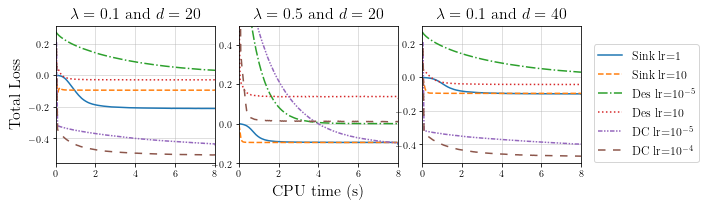

In [86]:
fig = plt.figure()
ls = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1)), (0, (5, 5))]
##################

for i, z in enumerate(dimlambrange):
    n = 0
    dim, lamb = z
    plt.subplot(131+i)
    if i == 0:
        l = []
    for s in itertools.product(sinkiterrange, sinklrrange):
        sinkiter, sinklr = s[0], s[1]        
        h, z = average(np.array(losses['sinkhorn'][(dim, lamb, sinkiter, sinklr)]), stepsize=5e-2)
        lz, = plt.plot(h, z, ls[n])
        n+=1
        if i==0:
            l.append(lz)
        
    for descentlr in descentlrrange:
        h, z = average(np.array(losses['descent'][(dim, lamb, descentlr)]), stepsize=5e-2)
        lz, = plt.plot(h,z, linestyle=ls[n])
        n+=1
        if i==0:
            l.append(lz)
            
    for s in itertools.product(dcdualiterrange, dclrrange):
        dcdualiter, dclr = s[0], s[1]
        h, z = average(np.array(losses['dc'][(dim, lamb, dcdualiter, dclr)]), stepsize=5e-2)
        lz, = plt.plot(h, z, linestyle=ls[n])
        n+=1
        if i==0:
            l.append(lz)

    plt.title('$\lambda={}$ and $d={}$'.format(lamb, dim), fontsize=16)
    if i==0:
        plt.ylabel('Total Loss',fontsize=16)
    if i==1:
        plt.ylim(-0.2, 0.5)
        plt.xlabel('CPU time (s)',fontsize=16)
    #else:
        #plt.tick_params(axis='y', labelleft=False)
    plt.xlim(0, 8)
    plt.grid(alpha=0.5)

labels = ['Sink lr=1', 'Sink lr=10', 'Des lr=$10^{-5}$', 'Des lr=10', 'DC lr=$10^{-5}$', 'DC lr=$10^{-4}$']
fig.set_figheight(2.8)
fig.set_figwidth(10)
plt.subplots_adjust(left=0.1, right=0.83, wspace=0.15, hspace=0, bottom=0.2)
fig.legend(l, labels, 'right', fontsize=12)
plt.savefig('figures/linear-toy.pgf')
plt.show()